TO DO: Create a dataloader that performs the transition to 3channel image, or figure out how to load in a 1 channel architecture
Test: mixed precision

In [16]:
import fastbook
fastbook.setup_book()

In [81]:

from fastbook import *
from fastai.vision.widgets import *
import skimage
from skimage import io as skio
import numpy
from PIL import Image, ImageEnhance
from torchvision import transforms

In [18]:
path =Path("D:/pytorch/data/2Dprojection_to_3D")
Path.BASE_PATH =path
image_list = (path/'325Downsample_2D').ls()


## Convert the input 16bit images into tensors from 0-1 using the min-max from the whole training batch. There could be issues here related to speckles and such

In [19]:
#Potential problem here, the 16bit images is squished into a narrow float range before being normalized out to 0-1
#Attempting to use tensors for speed when scaling to 3D GB data

#added - add 3 columns and reshape to a 3channel image to make it easier to use with the fastai model batching
# image_tensors = [tensor(skimage.img_as_float( np.transpose( np.repeat( np.asarray(Image.open(o))[:, :, np.newaxis], 3, axis=2), (2,0,1)) )) for o in image_list]


In [20]:
# #normalize the dataset to min-max
# stacked_images_tensor = torch.stack(image_tensors)
# stacked_images_tensor.shape
# max = torch.max(stacked_images_tensor)
# min = torch.min(stacked_images_tensor)
# #considering min*0.98 and max*0.98 to reduce error from speckles
# normal_stacked_images_tensor = (stacked_images_tensor-min)/(max-min)
# # df = pd.DataFrame(image1_tensor)
# # df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

In [21]:
# ##########################################
# ## Replace this all with a better dataloader
# ## Requires dummy files to be in place in the images folder
# #########################################

# numpy_array = [(o.numpy()*255).astype(numpy.uint8) for o in normal_stacked_images_tensor]

# from tifffile import imsave
# image_list_output = (path/'images').ls()
# zippy = zip(image_list_output, (numpy_array))
# #list(zippy)
# [imsave(str(a),b) for a,b in zippy]

In [49]:
class PILImageGray(PILImage): _show_args,_open_args = {'cmap':'Gray'},{'mode': 'I;16'} # Used for loading RGBA input images

In [22]:
#model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=8)

In [103]:
#Notes - need the ImageBlock to take PILImageBW to not treat the incoming images as RGB

import fastbook
fastbook.setup_book()
from fastbook import *
fnames = get_image_files(path/"325Downsample_2D")
def get_label_filename(name): return path/'325Downsample_3D'/f'{name.stem[0:-3]}.tif'
def validation_split (r):  return os.path.basename(r)[0:-4].split("_")[3] == "R0003" or os.path.basename(r)[0:-4].split("_")[3] == "R0006"
# def to_3_channels(x):
#     return torch.cat((x, x, x), dim=1)
item_tfms = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean = 0.5, std=0.5),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomHorizontalFlip(0.3),
    # transforms.Grayscale(1),
    # transforms.Lambda(lambda a : a.unsqueeze_(0).expand_(1,325,325,325)),
    # transforms.Lambda(lambda a : torch.cat_((a,a,a), dim=0)),

    transforms.RandomApply([transforms.RandomRotation((90,90))], p=0.5)

])

dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), ImageBlock),
                  get_items = get_image_files,
                  item_tfms=item_tfms,

                  get_y= get_label_filename,
                  splitter = FuncSplitter(validation_split)#,
                  #batch_tfms =aug_transforms(size=(325,325,325))
                  )
dls = dblock.dataloaders(path/"325Downsample_2D", bs=8, shuffle=true)

learn = unet_learner(dls, resnet34,n_in=1,n_out=325,loss_func=L1LossFlat(), lr=0.01).to_fp16()


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [99]:
dls.

<bound method TfmdDL.show_batch of <fastai.data.core.TfmdDL object at 0x000001EF4D6313C0>>

In [76]:
print(thing)

(TensorImage([[[103, 110, 112,  ..., 108, 102, 111],
         [112, 110, 117,  ..., 111, 109, 110],
         [116, 122, 112,  ..., 116, 115, 104],
         ...,
         [117, 113, 105,  ..., 110, 112,  90],
         [116, 109, 104,  ..., 102,  95,  87],
         [118, 112, 103,  ..., 106, 106, 100]],

        [[123, 128, 133,  ..., 121, 125, 124],
         [114, 115, 115,  ..., 113, 120, 123],
         [125, 124, 117,  ..., 118, 119, 133],
         ...,
         [131, 115,  92,  ..., 106,  95, 107],
         [128, 114, 100,  ..., 112, 121, 120],
         [118, 119, 118,  ..., 113, 125, 119]],

        [[108, 105,  98,  ...,  87,  96,  89],
         [108, 104, 101,  ...,  88,  95,  90],
         [ 95,  87,  92,  ..., 101, 108,  92],
         ...,
         [102,  89, 105,  ..., 116, 120, 104],
         [ 96,  91, 101,  ..., 102,  96,  94],
         [ 91,  87,  83,  ...,  89,  83,  98]]]), TensorBase([[[-0.3481, -0.2250, -0.1892,  ..., -0.2573, -0.3699, -0.2025],
         [-0.1908, -0.23

In [38]:
# fnames = get_image_files(path/"325Downsample_2D")
# def get_label_filename(name): return path/'325Downsample_3D'/f'{name.stem[0:-3]}.tif'
# def validation_split (r):  return os.path.basename(r)[0:-4].split("_")[3] == "R0003" or os.path.basename(r)[0:-4].split("_")[3] == "R0006"
# dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
#                   get_items = get_image_files,
#                   get_y= get_label_filename,
#                   splitter = FuncSplitter(validation_split)
#                   #batch_tfms =aug_transforms(size=(512,512))
#                   )
# dls = dblock.dataloaders(path, bs=8)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [104]:
learn.fine_tune(50)
learn.unfreeze
learn.fit_one_cycle(150, lr_max=slice(1e-6, 5e-2))

epoch,train_loss,valid_loss,time


d:\Anaconda\envs\fastai2\lib\site-packages\torch\_tensor.py:1142: UserWarning: Using a target size (torch.Size([2535000])) that is different to the input size (torch.Size([274625000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


RuntimeError: The size of tensor a (274625000) must match the size of tensor b (2535000) at non-singleton dimension 0

In [37]:
learn.export('fish_yolk_segmentation_20220619.pkl')

In [45]:
learn.fine_tune(50)
learn.unfreeze
learn.fit_one_cycle(150, lr_max=slice(1e-6, 1e-3))


epoch,train_loss,valid_loss,time


RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[8, 3, 325, 325] to have 1 channels, but got 3 channels instead

In [14]:
learn.export()

In [ ]:
learn.unfreeze
learn.fit_one_cycle(8, lr_max=slice(1e-6, 1e-3))

In [25]:
learn.load("morning_100").to_fp16()

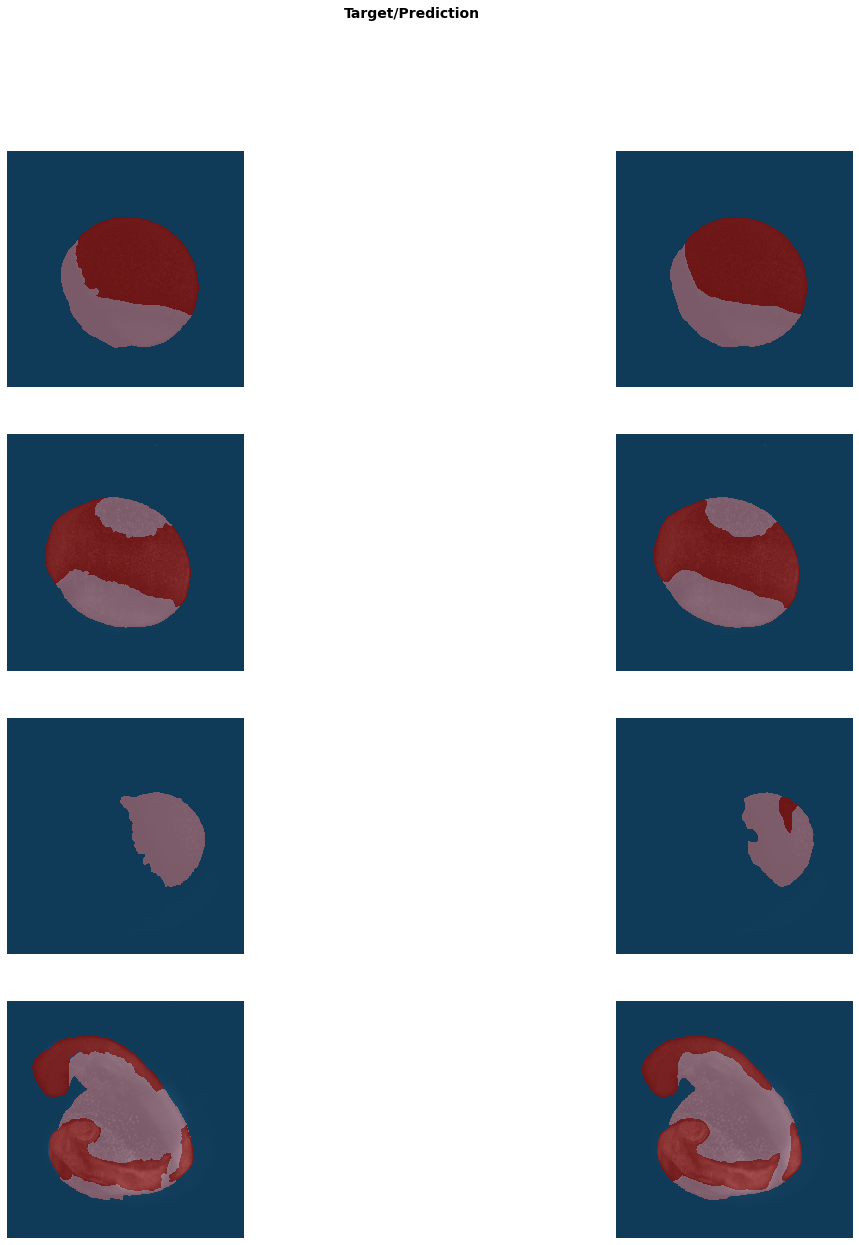

In [26]:
learn.show_results(max_n=4, figsize=(20,20))

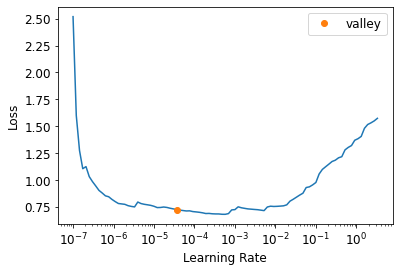

In [15]:
lr_steep = learn.lr_find()

In [ ]:
from fastai.test_utils import show_install
show_install()

D:\pytorch\data\2D_FishYolk\images\embryo11_011.tif


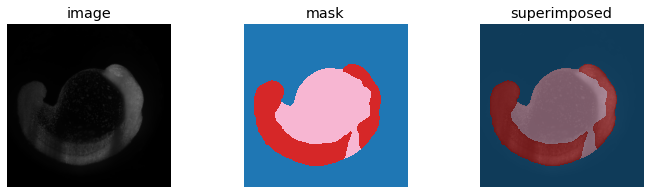

In [27]:
#Pick any image to get a prediction
n=26
fnames = get_image_files(path/"images")
img = PILImage.create(fnames[n])
zebrafish_classifier = load_learner(path/'export.pkl')
#zebrafish_classifier.load('valid_loss_1')
pred,pred_idx,probs = zebrafish_classifier.predict(fnames[n])
#img2 =Image.fromarray(pred.numpy())
#img2.show()
print(fnames[n])
_,axs = plt.subplots(1,3, figsize=(12,3))
img.show(ctx=axs[0], title='image')
pred.show(alpha=1, ctx=axs[1], vmin=0, vmax=3, title='mask')
img.show(ctx=axs[2], title='superimposed')
pred.show(ctx=axs[2], vmin=0, vmax=3);

In [29]:
btn_upload= widgets.FileUpload()
btn_upload


FileUpload(value={}, description='Upload')

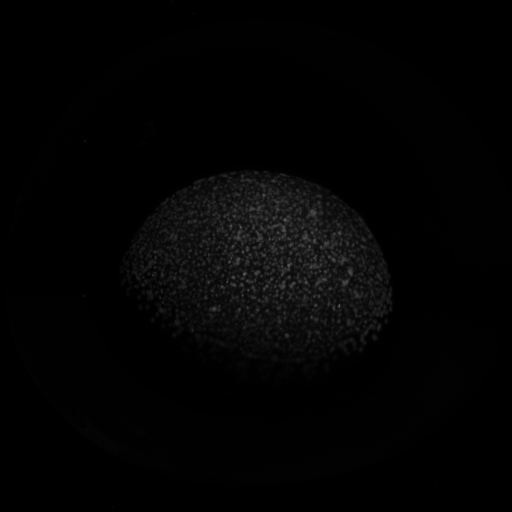

In [31]:
img = PILImage.create(btn_upload.data[-1])
img

In [32]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [34]:
zebrafish_classifier = load_learner(path/'export.pkl')
pred,pred_idx,probs = zebrafish_classifier.predict(img)

In [42]:

out_pl = widgets.Output()
out_pl_mask = widgets.Output()
lbl_pred = widgets.Label()
zebrafish_classifier = load_learner(path/'export.pkl')
btn_run = widgets.Button(description='Process')
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    enhancer = ImageEnhance.Brightness(img)
    factor = 10 
    im_output = enhancer.enhance(factor)
    with out_pl: display(im_output.to_thumb(128,128))
        
    pred,pred_idx,probs=zebrafish_classifier.predict(img)
    with out_pl_mask: pred.show(alpha=1, vmin=0, vmax=3, title='mask')
    
    #lbl_pred.value = f'Predicted age: {age[0]};'

btn_run.on_click(on_click_classify)


In [43]:
btn_upload= widgets.FileUpload()

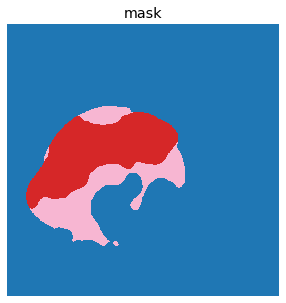

In [44]:
VBox([widgets.Label('Upload a grayscale zebrafish embryo image'), 
      btn_upload, btn_run, out_pl, out_pl_mask])

In [ ]:
cam_img = PILImage.create(img_f)
test_eq(cam_img.size, (512,512))
tmask = Transform(PILMask.create)
mask = tmask(lbl_f)
test_eq(type(mask), PILMask)
test_eq(mask.size, (512,512))
_,axs = plt.subplots(1,3, figsize=(12,3))
cam_img.show(ctx=axs[0], title='image')
mask.show(alpha=1, ctx=axs[1], vmin=0, vmax=3, title='mask')
cam_img.show(ctx=axs[2], title='superimposed')
mask.show(ctx=axs[2], vmin=0, vmax=3);

get_y_fn = lambda o: path/'labels'/f'{o.stem}_annotationLabels.tif'
def get_label_filename(name, path): return path/'labels'/f'{name.stem}_annotationLabels.tif'